<a href="https://colab.research.google.com/github/PaulGG-Code/Blockchain/blob/master/Bitcoin_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

sns.set_palette('Set2')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=EUR&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2015-02-25,209.91,211.92,207.04,209.32,2488.05,521951.29
2015-02-26,210.06,211.75,205.98,209.91,2388.87,500179.17
2015-02-27,221.50,224.54,209.18,210.06,4762.30,1043451.37
2015-02-28,220.78,222.69,214.28,221.50,1589.25,350513.95
2015-03-01,224.59,225.15,214.86,220.78,2096.98,462063.63


In [3]:
target_col = 'close'

In [4]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

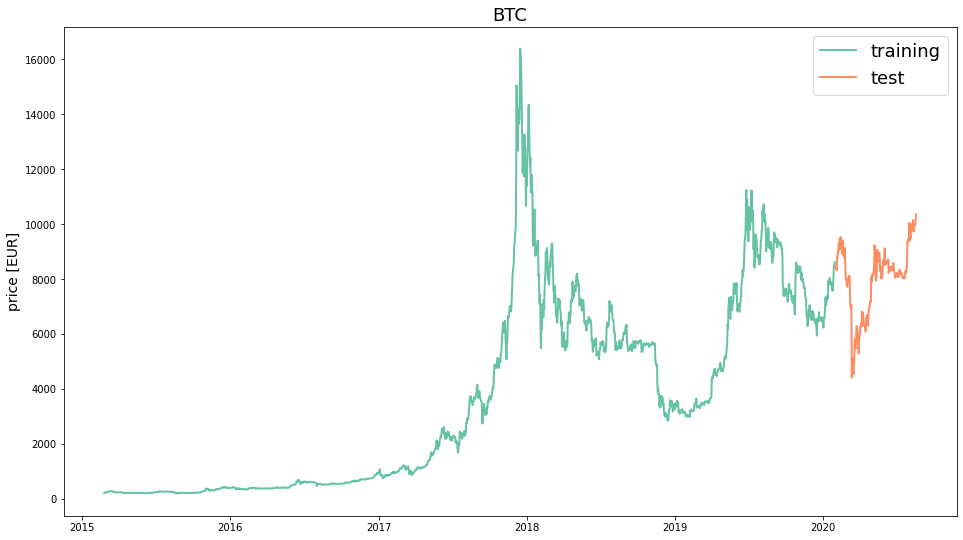

In [5]:
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [EUR]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

train, test = train_test_split(hist, test_size=0.1)
line_plot(train.close, test.close, 'training', 'test', 'BTC')

In [6]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1

In [7]:
def extract_window_data(df, window=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [8]:
def prepare_data(df, window=7, zero_base=True, test_size=0.1):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.close[window:].values
    y_test = test_data.close[window:].values
    if zero_base:
        y_train = y_train / train_data.close[:-window].values - 1
        y_test = y_test / test_data.close[:-window].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [9]:
def build_lstm_model(input_data, output_size, neurons=20,
                     activ_func='linear', dropout=0.25,
                     loss='mae', optimizer='adam'):
  
    model = Sequential()
    
    model.add(LSTM(neurons, input_shape=(
              input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [10]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [11]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

In [12]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
449/449 [==============================] - 1s 3ms/step - loss: 0.0591
Epoch 2/50
449/449 [==============================] - 1s 3ms/step - loss: 0.0427
Epoch 3/50
449/449 [==============================] - 1s 3ms/step - loss: 0.0359
Epoch 4/50
449/449 [==============================] - 1s 3ms/step - loss: 0.0333
Epoch 5/50
449/449 [==============================] - 1s 3ms/step - loss: 0.0324
Epoch 6/50
449/449 [==============================] - 1s 3ms/step - loss: 0.0306
Epoch 7/50
449/449 [==============================] - 1s 3ms/step - loss: 0.0296
Epoch 8/50
449/449 [==============================] - 1s 3ms/step - loss: 0.0289
Epoch 9/50
449/449 [==============================] - 1s 3ms/step - loss: 0.0291
Epoch 10/50
449/449 [==============================] - 1s 3ms/step - loss: 0.0285
Epoch 11/50
449/449 [==============================] - 1s 3ms/step - loss: 0.0288
Epoch 12/50
449/449 [==============================] - 1s 3ms/step - loss: 0.0278
Epoch 13/50
449/449 [====

In [13]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

In [14]:
mean_absolute_error(preds, y_test)

0.025444996225807513

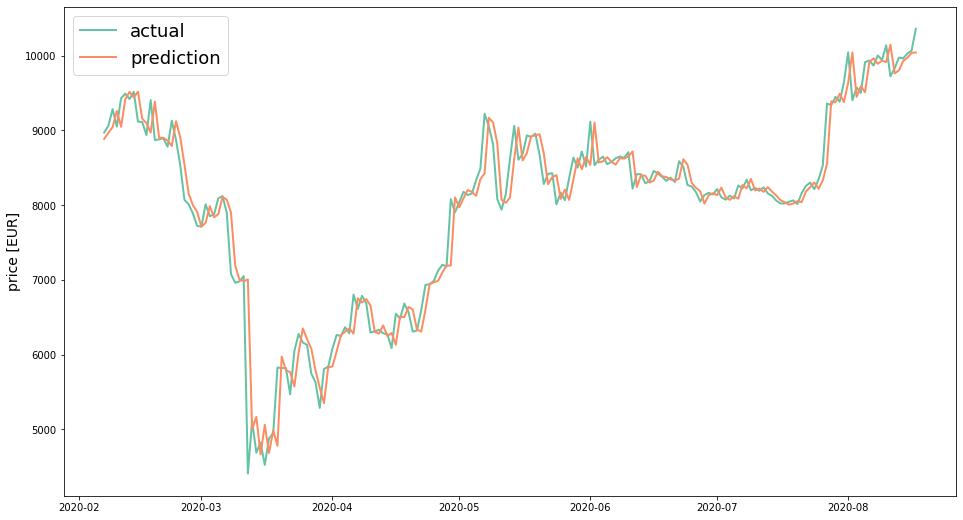

In [15]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction')

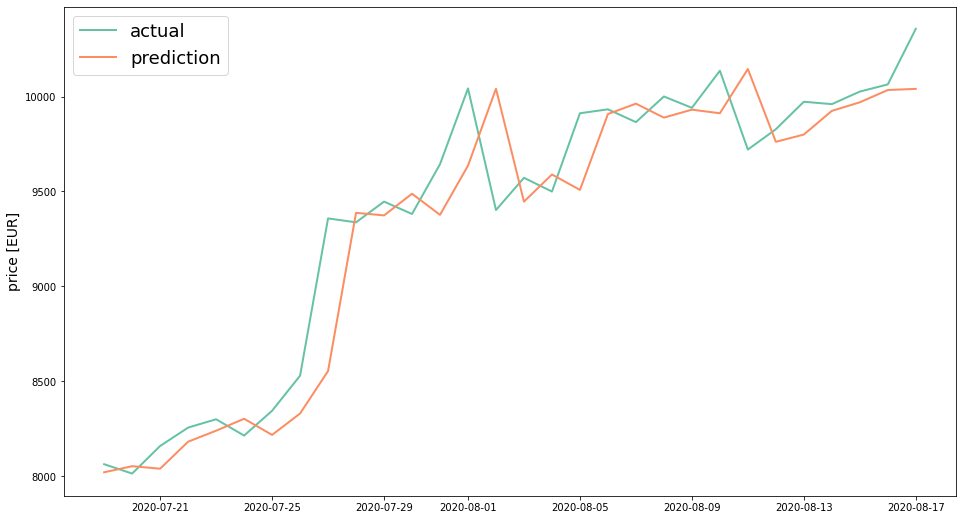

In [16]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction')

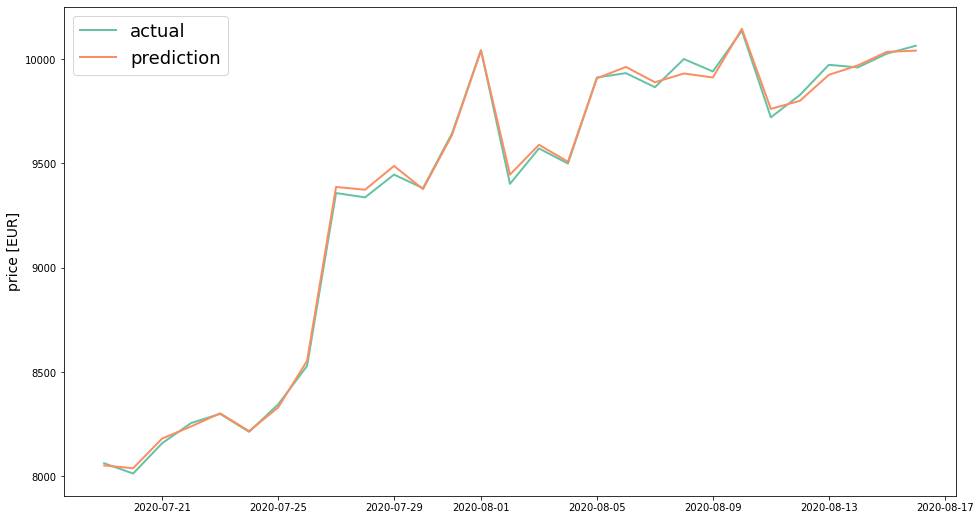

In [17]:
line_plot(targets[-n_points:][:-1], preds[-n_points:].shift(-1), 'actual', 'prediction')

In [18]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

In [19]:
def dual_line_plot(line1, line2, line3, line4, label1=None, label2=None, title='', lw=2):
    import matplotlib.dates as mdates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
    ax1.plot(line1, label=label1, linewidth=lw)
    ax1.plot(line2, label=label2, linewidth=lw)
    ax2.plot(line3, label=label1, linewidth=lw)
    ax2.plot(line4, label=label2, linewidth=lw)
    ax2.set_xticks(ax1.get_xticks())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_ylabel('daily returns', fontsize=14)
    ax2.legend(loc='best', fontsize=18);

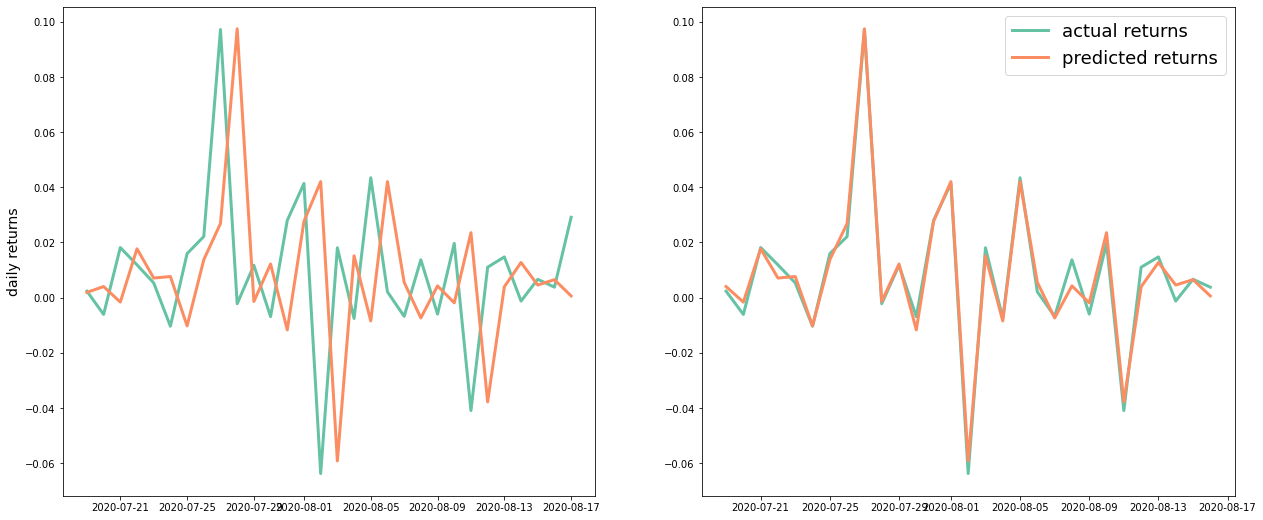

In [20]:
dual_line_plot(actual_returns[-n_points:],
          predicted_returns[-n_points:],
          actual_returns[-n_points:][:-1],
          predicted_returns[-n_points:].shift(-1),
          'actual returns', 'predicted returns', lw=3)

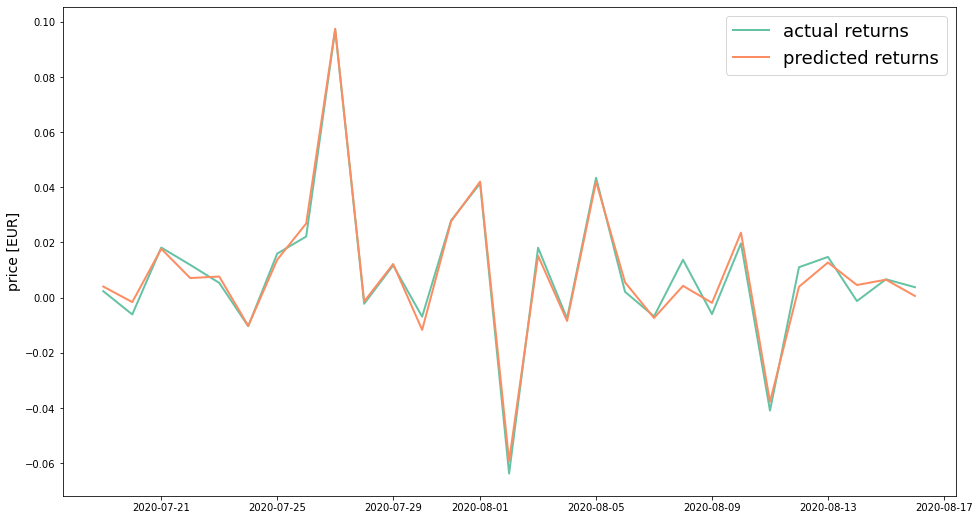

In [21]:
line_plot(actual_returns[-n_points:][:-1], predicted_returns[-n_points:].shift(-1),
           'actual returns', 'predicted returns')

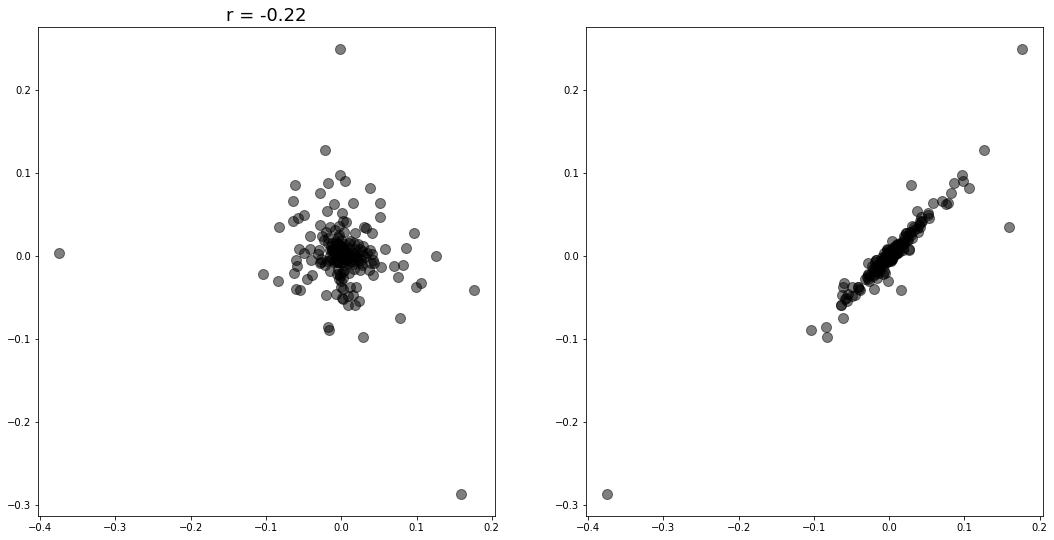

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)

# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k', marker='o', alpha=0.5, s=100)